In [1]:
#Imports
import illustris_python as il
import numpy as np
import matplotlib.pyplot as plt 
import scipy
from astropy.table import Table

In [2]:
"""
100-1 Loading
"""
basePath = 'D:/Buhv2020Work/illustris-100-1/output'
snapshot_ind = 99


"""
Loading TNG 100-3
basePath = 'D:/Buhv2020Work/Illustris-3/output'
snapshot_ind = 99 
"""

#Header gives basic group info
header = il.groupcat.loadHeader(basePath, snapshot_ind)
#Scale Factor
scale_factor = header['Time']

#Load in the subhalo/halo tables
subhalo_grp = il.groupcat.loadSubhalos(basePath, snapshot_ind)
halo_grp = il.groupcat.loadHalos(basePath, snapshot_ind)

#Get the keys for each
subhalo_keys = (list(subhalo_grp.keys()))
halo_keys = (list(halo_grp.keys()))

#Index the table
subhalo_table = Table({'Index': [x+1 for x in range(subhalo_grp['count'])]})
#Tabulate the subhalo info
for i in range(1, len(subhalo_keys)):
    subhalo_table.add_column(subhalo_grp[str(subhalo_keys[i])], name=str(subhalo_keys[i]))

#Tabulate the halo info
for i in range(1, len(halo_keys)):
    subhalo_data = [0] * len(subhalo_table)
    for j in range(0, len(subhalo_table)):
        subhalo_data[j] = halo_grp[str(halo_keys[i])][subhalo_table['SubhaloGrNr'][j]]
    subhalo_table.add_column(subhalo_data,name=str(halo_keys[i]))

is_central = np.array([0] * len(subhalo_table), dtype=bool)
temp = halo_grp['GroupFirstSub']>-1
groupfirstsub = np.array(halo_grp['GroupFirstSub'])
is_central[groupfirstsub[temp]]=True
subhalo_table.add_column(is_central,name=str("IsCentral"))
subhalo_table.add_column(subhalo_table["SubhaloMassInHalfRadType"][:,4], name=str("StellarMassHalfRad"))
subhalo_table.add_column(subhalo_table["SubhaloMassType"][:,4], name=str("StellarMass"))


In [3]:
print(len(groupfirstsub))
print(len(groupfirstsub[temp]))

6291349
3430706


In [4]:
def cut_color_lines(table, min_gmr, max_gmr):
    mag = table['SubhaloStellarPhotometrics']
    gmr_cut_low = (mag[:,4]-mag[:,5]) > min_gmr
    gmr_cut_high = (mag[:,4]-mag[:,5])< max_gmr
    return  table[gmr_cut_low & gmr_cut_high]

def cut_color_squares(table, min_gmr, max_gmr, min_rmz, max_rmz):
    #0.46, 0.34 min_gmr and max_rmz for my original "blue"
    #0.66, 0.52 min_gmr and min_rmz for my original "red"
    mag = table['SubhaloStellarPhotometrics']
    gmr_cut_low = (mag[:,4]-mag[:,5]) > min_gmr
    gmr_cut_high = (mag[:,4]-mag[:,5])< max_gmr
    rmz_cut_low = (mag[:,5]-mag[:,7])> min_rmz
    rmz_cut_high = (mag[:,5]-mag[:,7]) < max_rmz
    return table[gmr_cut_low & gmr_cut_high & rmz_cut_low & rmz_cut_high]

def cut_mass_high(table, field, num):
    if(field == "SubhaloMassType" or field == "SubhaloMassInRadType"):
        subhalomass = np.array(np.log10(table[field][:,4]*1e10/0.704))
        mask = subhalomass > num
        return table[mask]
    else:
        subhalomass = np.array(np.log10(table[field]*1e10/0.704))
        mask = subhalomass > num
        return table[mask]

def cut_mass_low(table, field, num):
    if(field == "SubhaloMassType" or field == "SubhaloMassInRadType"):
        subhalomass = np.array(np.log10(table[field][:,4]*1e10/0.704))
        mask = subhalomass < num
        return table[mask]
    else:
        subhalomass = np.array(np.log10(table[field]*1e10/0.704))
        mask = subhalomass < num
        return table[mask]

In [5]:
print(len(subhalo_table))
all_galaxies = subhalo_table[subhalo_table['SubhaloFlag']]
all_galaxies = all_galaxies[all_galaxies['SubhaloMass']!=0]
all_galaxies = cut_mass_high(all_galaxies, "SubhaloMassType", 8)
print(len(all_galaxies))
print('Masking step 1 - remove bad subhalos - complete \n')

centrals = all_galaxies[all_galaxies['IsCentral']]
satellites = all_galaxies[np.bitwise_not(all_galaxies['IsCentral'])]
#del all_galaxies #Use for 100-1
centrals_in_cluster = centrals[centrals['GroupNsubs']>1]
field_galaxies = centrals[centrals['GroupNsubs']<=1]
print("Central galaxies: " + str(len(centrals)))
print("Satellite galaxies: " + str(len(satellites)))
print("Central galaxies that are not alone in their halo: " + str(len(centrals_in_cluster)))
print("Field Galaxies: " + str(len(field_galaxies)))
print("Masking step 2 - separate all centrals, satellites, and centrals with satellites in same halo, complete \n")


4371211


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10


49278
Masking step 1 - remove bad subhalos - complete 

Central galaxies: 27392
Satellite galaxies: 21886
Central galaxies that are not alone in their halo: 25122
Field Galaxies: 2270
Masking step 2 - separate all centrals, satellites, and centrals with satellites in same halo, complete 



In [6]:
print("Difference between average halo particle numbers and subhalo particle numbers (stellar particles)")
print(np.mean(field_galaxies['GroupLenType'][:,4])-np.mean(field_galaxies['SubhaloLenType'][:,4]))
print("Mean number of stellar halo particles")
print(np.mean(field_galaxies['GroupLenType'][:,4]))

Difference between average halo particle numbers and subhalo particle numbers (stellar particles)
2.8982378854625495
Mean number of stellar halo particles
559.1136563876652


In [7]:
#Overall bands plot
def plot_all_bands(table):
    subhalomass = np.array(np.log10(table["SubhaloMassInHalfRad"]*1e10/0.704))
    mask = subhalomass > 10.3
    st = table[mask]

    fig, ax = plt.subplots(4,2)
    fig.set_size_inches(16,20)
    plt.subplots_adjust(hspace = 0.5)
    band_names = ['U', 'B', 'V','K', 'g', 'r', 'i', 'z']
    for bands in range(8):
        mag = st['SubhaloStellarPhotometrics'][:,bands]
        ax[bands%4][bands//4].hist(mag, bins=50)
        ax[bands%4][bands//4].set_xlabel('magnitude in ' + band_names[bands] + " band", fontsize = 16 )
        ax[bands%4][bands//4].set_ylabel('count', fontsize = 16)

    plt.show()

In [8]:
def mass_vs_gmr(table, table_name, mass_type):
    #Recreating Figure 3 from https://arxiv.org/pdf/1707.03395.pdf
    mag = table['SubhaloStellarPhotometrics'][:,4] - table['SubhaloStellarPhotometrics'][:,5]

    mass = np.array(np.log10(table[mass_type]*1e10/0.704))
    plt.ylabel("$\mathrm{g-r}$", fontsize = 20)
    plt.xlabel("Mass", fontsize = 20)
    plt.title(table_name)

    #heights, mass_bins, mag_bins = np.histogram2d(mass, mag, bins=50)
    #plt.contour(mass_bins[0:50],mag_bins[0:50], heights, colors=['red','orange','pink','green'])
    plt.hist2d(mass, mag, bins=100, cmap='viridis', cmin=0.1) #, range=[[9,12], [0,1]])
    plt.show()

In [66]:
def formation_rate_vs_gmr(table, table_name):
    #Recreating Figure 3 from https://arxiv.org/pdf/1707.03395.pdf
    table = table[table['SubhaloSFR']>0]
    mag = table['SubhaloStellarPhotometrics'][:,4] - table['SubhaloStellarPhotometrics'][:,5]
    plt.figure(figsize=(8,6))
    mass = table['SubhaloSFR']
    plt.xlabel("$\mathrm{g-r}$", fontsize = 14)
    plt.ylabel("Stellar Formation Rate: Msun/yr", fontsize = 14)
    plt.title(table_name, fontsize=16)
    
    #heights, mass_bins, mag_bins = np.histogram2d(mass, mag, bins=50)
    #plt.contour(mass_bins[0:50],mag_bins[0:50], heights, colors=['red','orange','pink','green'])
    plt.hist2d(mag, mass, bins=100, cmap='viridis', range=[[0,0.9], [0,0.2]], cmin=0.1)
    plt.colorbar()
    plt.show()

In [59]:
def formation_rate_vs_mass(table, table_name, mass_type):
    #Recreating Figure 3 from https://arxiv.org/pdf/1707.03395.pdf
    table = table[table['SubhaloSFR']>0]
    mag = table['SubhaloStellarPhotometrics'][:,4] - table['SubhaloStellarPhotometrics'][:,5]
    table = table[mag<0.55] #mag cut 
    mass = np.array(np.log10(table[mass_type]*1e10/0.704))
    plt.figure(figsize=(8,6))
    sfr = table['SubhaloSFR']
    plt.xlabel("Mass", fontsize = 14)
    plt.ylabel("Stellar Formation Rate: Msun/yr", fontsize = 14)
    plt.title(table_name, fontsize=16)
    
    #heights, mass_bins, mag_bins = np.histogram2d(mass, mag, bins=50)
    #plt.contour(mass_bins[0:50],mag_bins[0:50], heights, colors=['red','orange','pink','green'])
    plt.hist2d(mass, sfr, bins=100, cmap='viridis', cmin=0.1, range=[[8,12.5],[0,1]])
    plt.colorbar()
    plt.show()

In [10]:
def hydrogen_rate_vs_gmr(table, table_name):
    #Recreating Figure 3 from https://arxiv.org/pdf/1707.03395.pdf
    #table = table[table['SubhaloStarMetalFractions']>0]
    mag = table['SubhaloStellarPhotometrics'][:,4] - table['SubhaloStellarPhotometrics'][:,5]
    plt.figure(figsize=(8,6))
    plt.xlabel("$\mathrm{g-r}$", fontsize = 14)
    plt.ylabel("Hydrogen Abundance", fontsize = 14)
    plt.title(table_name, fontsize=16)
    
    #heights, mass_bins, mag_bins = np.histogram2d(mass, mag, bins=50)
    #plt.contour(mass_bins[0:50],mag_bins[0:50], heights, colors=['red','orange','pink','green'])
    plt.hist2d(mag, table['SubhaloStarMetalFractions'][:,0], bins=100, cmap='viridis', cmin=0.1) #, range=[[0,0.9], [0.6,0.9]])
    plt.colorbar()
    plt.show()

In [11]:
def helium_rate_vs_gmr(table, table_name):
    #Recreating Figure 3 from https://arxiv.org/pdf/1707.03395.pdf
    #table = table[table['SubhaloStarMetalFractions']>0]
    mag = table['SubhaloStellarPhotometrics'][:,4] - table['SubhaloStellarPhotometrics'][:,5]
    plt.figure(figsize=(8,6))
    plt.xlabel("$\mathrm{g-r}$", fontsize = 14)
    plt.ylabel("Helium Abundance", fontsize = 14)
    plt.title(table_name, fontsize=16)
    
    #heights, mass_bins, mag_bins = np.histogram2d(mass, mag, bins=50)
    #plt.contour(mass_bins[0:50],mag_bins[0:50], heights, colors=['red','orange','pink','green']
    plt.hist2d(mag, table['SubhaloStarMetalFractions'][:,1], bins=100, cmap='viridis', cmin=0.1) #, range=[[0,0.9], [0.6,0.9]])
    plt.colorbar()
    plt.show()

In [12]:
def element_rate_vs_gmr(table, table_name):
    elements = ['H', 'He', 'C', 'N', 'O', 'Ne', 'Mg', 'Si', 'Fe']
    for i in range (0, len(elements)):
        #Recreating Figure 3 from https://arxiv.org/pdf/1707.03395.pdf
        #table = table[table['SubhaloStarMetalFractions']>0]
        mag = table['SubhaloStellarPhotometrics'][:,4] - table['SubhaloStellarPhotometrics'][:,5]
        plt.figure(figsize=(6,4))
        plt.xlabel("$\mathrm{g-r}$", fontsize = 11)
        plt.ylabel(elements[i] + " Abundance", fontsize = 11)
        plt.title(elements[i] + " in " + table_name, fontsize=12)

        #heights, mass_bins, mag_bins = np.histogram2d(mass, mag, bins=50)
        #plt.contour(mass_bins[0:50],mag_bins[0:50], heights, colors=['red','orange','pink','green']
        plt.hist2d(mag, table['SubhaloStarMetalFractions'][:,i], bins=100, cmap='viridis', cmin=0.1) #, range=[[0,0.9], [0.6,0.9]])
        plt.colorbar()
        plt.show()


In [14]:
def gmr_mass_bins_hist(table, table_name, mass_type):
    bins = [9.0,9.5,10.0,10.5,11.0,11.5,12.0]
    fig, ax = plt.subplots(2,3)
    fig.set_size_inches(18,11)
    for i in range(0,6):
        s1 = cut_mass_high(table, mass_type, bins[i])
        s2 = cut_mass_low(table, mass_type, bins[i+1])
        mask2 = np.array(np.log10(s1[mass_type]*1e10/0.704)) < bins[i+1]
        s2 = s1[mask2]

        print(min(np.array(np.log10(s2[mass_type]*1e10/0.704))))
        print(max(np.array(np.log10(s2[mass_type]*1e10/0.704))))
        
        mag = s2['SubhaloStellarPhotometrics'][:,4] - s2['SubhaloStellarPhotometrics'][:,5]
        ax[i//3][i%3].hist(mag, bins=50) #, density=True)
        ax[i//3][i%3].set_title("Mass bin: "+str(bins[i])+"-"+str(bins[i+1]) + " for table: " + table_name)
        ax[i//3][i%3].set_xlabel('magnitude in g-r band', fontsize = 16 )
        ax[i//3][i%3].set_ylabel('count', fontsize = 16)

In [26]:
def color_color(mag, r1, r2, table_name):
    g_minus_r = mag[:,4]-mag[:,5]
    r_minus_z = mag[:,5]-mag[:,7]
    plt.figure(figsize=(10,8))
    #heights, rmz,gmr = np.histogram2d(r_minus_z,g_minus_r,bins=150)
    plt.hist2d(g_minus_r,r_minus_z, bins = 150, cmap='viridis', range=[[r1, 1], [r2, 1]], cmin = 0.1)
    plt.xlabel("$\mathrm{g-r}$", fontsize = 20)
    plt.ylabel("$\mathrm{r-z}$", fontsize = 20)
    plt.title("Color-Color plane plot for " + table_name, fontsize = 20)
    plt.colorbar()
    plt.grid(b=True, which='both', axis='both')
    #print(len(g_minus_r))
    #print(str(len(g_minus_r[g_minus_r>0.5])) + "\n")
    #levels = np.linspace(0, 40,num=4)
    #plt.contour(gmr[0:150],rmz[0:150], heights, levels=levels, 
                #extent=[0,0,0.8,0.7], colors=['red','orange','pink','green'])

In [16]:
def color_density(mag, band1, band2, band3, title):
    band_names = ['U', 'B', 'V','K', 'g', 'r', 'i', 'z']
    r = mag[:,band1]
    r_minus_z = mag[:,band2]-mag[:,band3]
    plt.figure(figsize=(8,6))
    plt.hist2d(r, r_minus_z, bins = 80, cmap='viridis', cmin=0.1)#, range=[[0, 0.7], [0, 0.8]])
    plt.ylabel(band_names[band2]+"-"+band_names[band3], fontsize = 20)
    plt.xlabel(band_names[band1], fontsize = 20)
    plt.title(title, fontsize = 20)
    plt.colorbar()

In [17]:
def galaxy_dist_vs_mass(table, table_name, color, mass_type):
    d = table['SubhaloPos']-table['GroupPos']
    dist = np.sqrt((d[0]/0.7)**2 + (d[1]/0.7)**2 +(d[2]/0.7)**2)
    mass = np.array(np.log10(table[mass_type]*1e10/0.704))
    plt.figure(figsize=(8,6))
    plt.scatter(mass, dist, s=2, color='red')
    plt.xlabel("Subhalo Mass in Half Rad")
    plt.ylabel("Distance in ckpc")
    plt.title("Distance of " + table_name + " from Halo Center vs. Mass." + "RED")
    plt.show()

In [18]:
def rotation_curve_vs_mass(table, table_name, color, mass_type):
    plt.figure(figsize=(10,8))
    mass = (np.log10(table[mass_type]*1e10/0.704))
    plt.scatter(table['SubhaloVmax'], mass, s=1.5)
    plt.title("Mass vs. max of rotation curve for " + color + " " + table_name)
    plt.xlabel("Maximum value of the spherically-averaged rotation curve. (km/s)", fontsize=14)
    plt.ylabel("Mass")
    plt.show()

In [19]:
def peculiar_velocity_vs_mass(table, table_name, color, mass_type):
    pec_vel_red = []
    mass_red=[]
    v=table['SubhaloVel'][i]-table['GroupVel']/scale_factor
    velocity = np.sqrt((v[0])**2 + (v[1])**2 +(v[2])**2)
    mass = np.array((np.log10(table[mass_type][i]*1e10/0.704)))

    plt.figure(figsize=(8,6))
    plt.scatter(mass_blue,pec_vel_blue, s=1.5, color = "blue")
    plt.title("Mass vs. Peculiar velocity of the group - blue", fontsize=14)
    plt.ylabel("Peculiar velocity of the group. (km/s)", fontsize=14)
    plt.xlabel("Mass", fontsize=14)
    plt.show()


In [20]:
#plot_all_bands(all_galaxies)

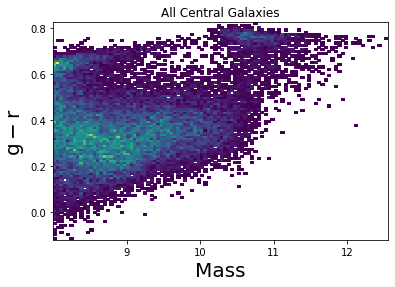

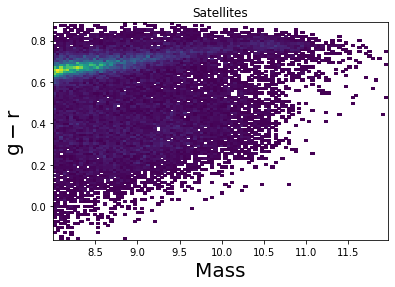

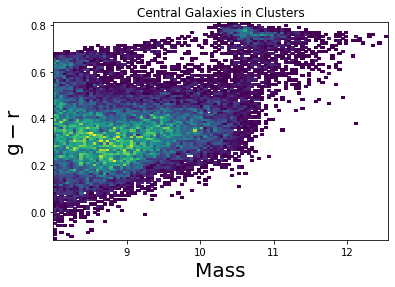

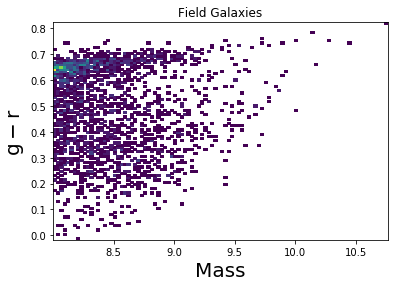

In [21]:
#mass_vs_gmr(all_galaxies, "All Galaxies", "StellarMass")
mass_vs_gmr(centrals, "All Central Galaxies", "StellarMass")
mass_vs_gmr(satellites, "Satellites", "StellarMass")
mass_vs_gmr(centrals_in_cluster, "Central Galaxies in Clusters", "StellarMass")
mass_vs_gmr(field_galaxies, "Field Galaxies", "StellarMass")

In [22]:
"""
Define color splits as per Tara's slide 24
"""

centrals_red = cut_mass_high(cut_color_lines(centrals, 0.6, 1000), "StellarMass" ,10.2)
centrals_green = cut_mass_low(cut_color_lines(centrals, 0.6, 1000), "StellarMass" ,10.2)
centrals_blue = cut_color_lines(centrals, 0, 0.5)

satellites_red = cut_mass_high(cut_color_lines(satellites, 0.6, 1000), "StellarMass" ,10.2)
satellites_green = cut_mass_low(cut_color_lines(satellites, 0.6, 1000), "StellarMass" ,10.2)
satellites_blue = cut_color_lines(satellites, 0, 0.5)

centrals_in_cluster_red = cut_mass_high(cut_color_lines(centrals_in_cluster, 0.6, 1000), "StellarMass" ,10.2)
centrals_in_cluster_green = cut_mass_low(cut_color_lines(centrals_in_cluster, 0.6, 1000), "StellarMass" ,10.2)
centrals_in_cluster_blue = cut_color_lines(centrals_in_cluster, 0, 0.5)

field_galaxies_red = cut_mass_high(cut_color_lines(field_galaxies, 0.6, 1000), "StellarMass" ,10.2)
field_galaxies_green = cut_mass_low(cut_color_lines(field_galaxies, 0.6, 1000), "StellarMass" ,10.2)
field_galaxies_blue = cut_color_lines(field_galaxies, 0, 0.5)


print("Central galaxies red: " + str(len(centrals_red)))
print("Central galaxies green: " + str(len(centrals_green)))
print("Central galaxies blue: " + str(len(centrals_blue)))

print("Satellite galaxies red: " + str(len(satellites_red)))
print("Satellite galaxies green: " + str(len(satellites_green)))
print("Satellite galaxies blue: " + str(len(satellites_blue)))

print("Central galaxies that are not alone in their halo red: " + str(len(centrals_in_cluster_red)))
print("Central galaxies that are not alone in their halo green: " + str(len(centrals_in_cluster_green)))
print("Central galaxies that are not alone in their halo blue: " + str(len(centrals_in_cluster_blue)))

print("Field Galaxies red: " + str(len(field_galaxies_red)))
print("Field Galaxies green: " + str(len(field_galaxies_green)))
print("Field Galaxies blue: " + str(len(field_galaxies_blue)))

print("Masking step 3 - color bimodality for each type of galaxy, complete \n")


Central galaxies red: 1474
Central galaxies green: 1930
Central galaxies blue: 21777
Satellite galaxies red: 1191
Satellite galaxies green: 11374
Satellite galaxies blue: 7302
Central galaxies that are not alone in their halo red: 1471
Central galaxies that are not alone in their halo green: 1031
Central galaxies that are not alone in their halo blue: 20733
Field Galaxies red: 3
Field Galaxies green: 899
Field Galaxies blue: 1044
Masking step 3 - color bimodality for each type of galaxy, complete 



In [ ]:
gmr_mass_bins_hist(all_galaxies, "All Galaxies" ,"StellarMass")
gmr_mass_bins_hist(satellites, "Satellite Galaxy" ,"StellarMass")
gmr_mass_bins_hist(centrals_in_cluster, "Central In Cluster" ,"StellarMass")

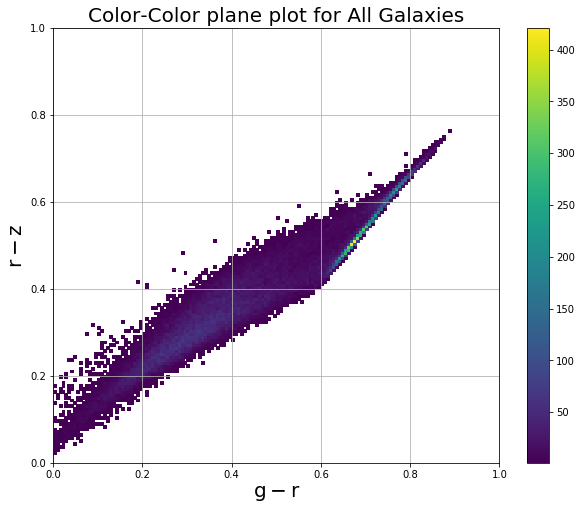

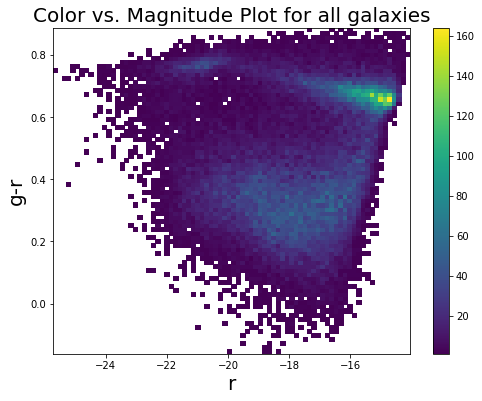

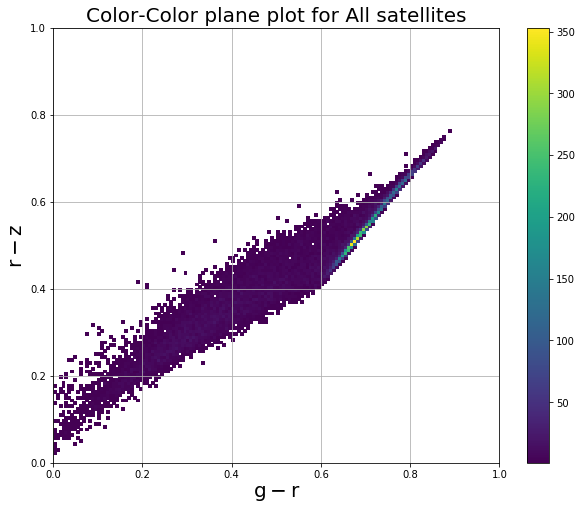

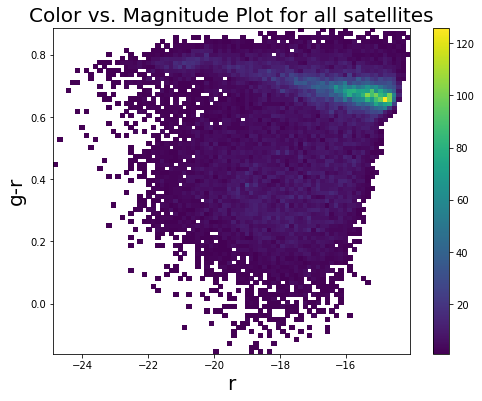

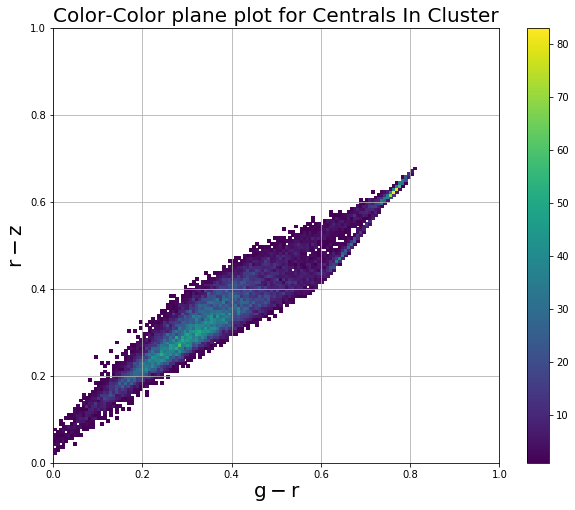

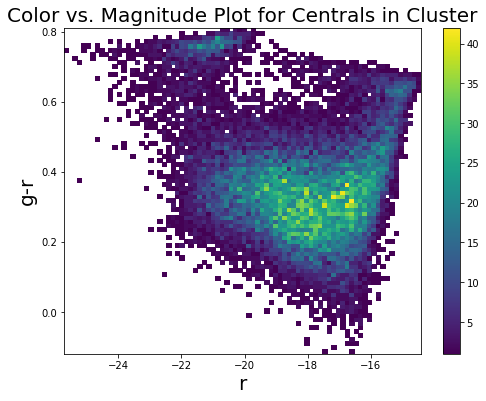

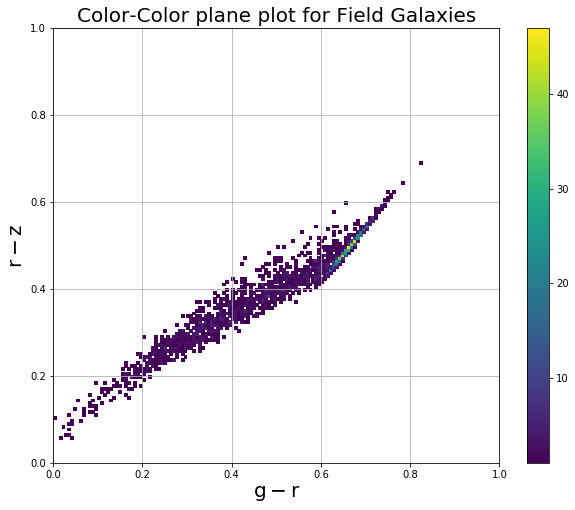

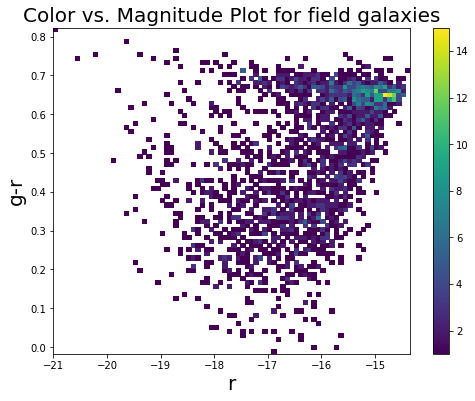

In [68]:
color_color(all_galaxies['SubhaloStellarPhotometrics'], 0.0, 0.0, "All Galaxies")
color_density(all_galaxies['SubhaloStellarPhotometrics'], 5, 4, 5, "Color vs. Magnitude Plot for all galaxies")
color_color(satellites['SubhaloStellarPhotometrics'], 0.0, 0.0, "All satellites")
color_density(satellites['SubhaloStellarPhotometrics'], 5, 4, 5, "Color vs. Magnitude Plot for all satellites")
color_color(centrals_in_cluster['SubhaloStellarPhotometrics'], 0.0, 0.0, "Centrals In Cluster")
color_density(centrals_in_cluster['SubhaloStellarPhotometrics'], 5, 4, 5, 
              "Color vs. Magnitude Plot for Centrals in Cluster")

color_color(field_galaxies['SubhaloStellarPhotometrics'], 0.0, 0.0, "Field Galaxies")

color_density(field_galaxies['SubhaloStellarPhotometrics'], 5, 4, 5, "Color vs. Magnitude Plot for field galaxies")

In [ ]:
testing = cut_mass_high(all_galaxies, "SubhaloMassInHalfRad", 9)
color_density(testing['SubhaloStellarPhotometrics'], 5,4, 5, "Color Magnitude for all galaxies masshalfrad>9")
testing = cut_mass_high(all_galaxies, "SubhaloMassInHalfRad", 9.5)
color_density(testing['SubhaloStellarPhotometrics'], 5,4, 5, "Color Magnitude for all galaxies masshalfrad>9.5")
# I-band magnitude 19.9
testing = cut_mass_high(all_galaxies, "SubhaloMassInHalfRad", 10.5)
color_density(testing['SubhaloStellarPhotometrics'], 5,4, 5, "Color Magnitude for all galaxies masshalfrad>10.5")
testing = cut_mass_high(all_galaxies, "SubhaloMassInHalfRad", 11)
color_density(testing['SubhaloStellarPhotometrics'], 5,4, 5, "Color Magnitude for all galaxies masshalfrad>11")

In [ ]:
#Color-evolution
formation_rate_vs_gmr(all_galaxies, "All Galaxies")
formation_rate_vs_gmr(centrals, "All Central Galaxies")
formation_rate_vs_gmr(satellites, "Satellites")
formation_rate_vs_gmr(centrals_in_cluster, "Central Galaxies in Clusters")
formation_rate_vs_gmr(field_galaxies, "Field Galaxies")

#Color-magnitude


In [ ]:
testing = cut_mass_high(centrals_in_cluster, "SubhaloMassInHalfRad", 9.4)
formation_rate_vs_gmr(testing, "Central Galaxies in Clusters, mass>10^9.4")


In [ ]:
hydrogen_rate_vs_gmr(all_galaxies, "All Galaxies")
hydrogen_rate_vs_gmr(centrals, "All Central Galaxies")
hydrogen_rate_vs_gmr(satellites, "Satellites")
hydrogen_rate_vs_gmr(centrals_in_cluster, "Central Galaxies in Clusters")
hydrogen_rate_vs_gmr(field_galaxies, "Field Galaxies")

In [ ]:
testing = cut_mass_high(centrals_in_cluster, "SubhaloMassInHalfRad", 10)
hydrogen_rate_vs_gmr(testing, "Central Galaxies in Clusters, mass>10^10")


In [ ]:
helium_rate_vs_gmr(all_galaxies, "All Galaxies")
helium_rate_vs_gmr(centrals, "All Central Galaxies")
helium_rate_vs_gmr(satellites, "Satellites")
helium_rate_vs_gmr(centrals_in_cluster, "Central Galaxies in Clusters")
helium_rate_vs_gmr(field_galaxies, "Field Galaxies")

In [ ]:
element_rate_vs_gmr(centrals_in_cluster, "Central Galaxies in Clusters")

In [ ]:
formation_rate_vs_mass(all_galaxies, "All Galaxies" ,"StellarMass")
formation_rate_vs_mass(centrals_in_cluster, "Central Galaxies in Clusters" ,"StellarMass")
formation_rate_vs_mass(satellites, "Satellites" ,"StellarMass")
formation_rate_vs_mass(field_galaxies, "Field Galaxies" ,"StellarMass")
